In [ ]:
import numpy
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [63]:
adult_icu_raw = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/adult_icu")
print(adult_icu_raw.shape)
print(list(adult_icu_raw.columns))
adult_icu_raw = adult_icu_raw.drop(['subject_id','hadm_id','icustay_id'],axis=1)
scaler = preprocessing.StandardScaler()
adult_icu_scaled = scaler.fit_transform(adult_icu)
adult_icu_scaled = pd.DataFrame(adult_icu_scaled, columns=adult_icu_raw.columns)
adult_icu_raw.head()

(27348, 62)
['subject_id', 'hadm_id', 'icustay_id', 'age', 'mort_icu', 'first_hosp_stay', 'first_icu_stay', 'adult_icu', 'eth_asian', 'eth_black', 'eth_hispanic', 'eth_other', 'eth_white', 'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN', 'admType_URGENT', 'heartrate_min', 'heartrate_max', 'heartrate_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose', 'hematocrit', 'hemoglobin', 'lactate', 'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc', 'train']


,age,mort_icu,first_hosp_stay,first_icu_stay,adult_icu,eth_asian,eth_black,eth_hispanic,eth_other,eth_white,...,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,train
0,76.0,0,1,1,1,0,0,0,0,1,...,4.8,282.0,5.4,30.7,1.3,13.5,136.0,53.0,12.7,0
1,65.0,0,1,1,1,0,0,0,0,1,...,8.5,315.0,5.4,139.0,1.4,14.6,138.0,62.0,10.6,0
2,41.0,1,1,1,1,0,0,0,1,0,...,2.9,258.0,2.8,21.7,1.1,12.7,140.0,16.0,7.5,1
3,72.0,0,1,1,1,0,0,0,0,1,...,6.6,156.0,4.9,55.2,1.7,15.9,138.0,28.0,8.4,1
4,39.0,0,1,1,1,0,0,0,0,1,...,3.9,216.0,3.5,44.1,1.2,13.7,139.0,13.0,16.6,1


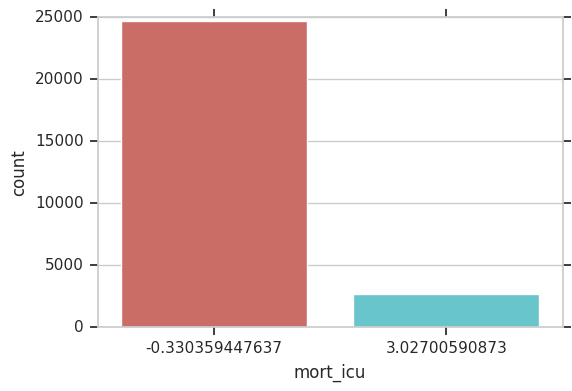

In [62]:
sns.countplot(x='mort_icu',data=adult_icu_scaled, palette='hls')
plt.show()

In [53]:
X = adult_icu_scaled.drop(['mort_icu'],axis=1)
X_train,X_test = X.loc[X['train']==1],X.loc[X['train']==0]
X_train,X_test = X_train.drop(['train'],axis=1),X_test.drop(['train'],axis=1)
Y = adult_icu_scaled[['mort_icu','train']] 
Y_train,Y_test = Y.loc[Y['train']==1],Y.loc[Y['train']==0]
Y_train,Y_test = Y_train.drop(['train'],axis=1).values.squeeze(),Y_test.drop(['train'],axis=1).values.squeeze()

In [68]:
classifier = LogisticRegression(random_state=0,penalty="l2", C=1)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
matrix = confusion_matrix(Y_test, Y_pred)
print(matrix)

[[7234   66]
 [ 730   78]]


In [65]:
classifier.score(X_train, Y_train)

0.90618503118503113

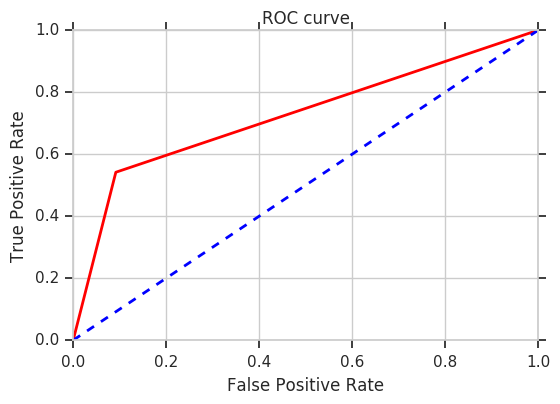

In [69]:
fpr, tpr,_=roc_curve(Y_pred,Y_test)
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [70]:
roc_auc_score(Y_pred,Y_test)

0.72500209275071148

In [3]:
adult_notes_raw = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/adult_notes")
adult_notes_raw = adult_notes_raw.drop(['subject_id','hadm_id','icustay_id'],axis=1)
print(adult_notes_raw.shape)
adult_notes_raw.head()

(27348, 3)


,chartext,train,mort_icu
0,[**2101-10-21**] 1:00 AM\n CHEST (PORTABLE AP)...,0,0
1,[**2175-5-31**] 11:03 AM\n RENAL TRANSPLANT U....,0,0
2,[**2149-11-10**] 11:07 AM\n CT HEAD W/O CONTRA...,1,1
3,ADMIT NOTE\nPLEASE SEE ADMISSION HISTORY/FHP.\...,1,0
4,[**2167-1-9**] 6:11 AM\n CHEST (PORTABLE AP) ...,1,0


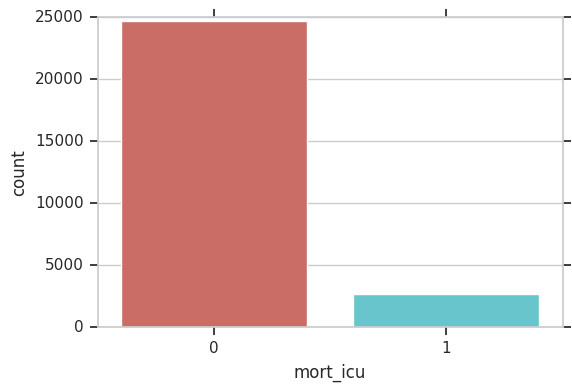

In [4]:
sns.countplot(x='mort_icu',data=adult_notes_raw, palette='hls')
plt.show()

In [5]:
#deleting punctuation
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
adult_notes_raw['chartext'].dropna(inplace=True)
adult_notes_raw.chartext = adult_notes_raw.chartext.apply(lambda x: tokenizer.tokenize(x))
adult_notes_raw.head()

,chartext,train,mort_icu
0,"[2101, 10, 21, 1, 00, AM, CHEST, PORTABLE, AP,...",0,0
1,"[2175, 5, 31, 11, 03, AM, RENAL, TRANSPLANT, U...",0,0
2,"[2149, 11, 10, 11, 07, AM, CT, HEAD, W, O, CON...",1,1
3,"[ADMIT, NOTE, PLEASE, SEE, ADMISSION, HISTORY,...",1,0
4,"[2167, 1, 9, 6, 11, AM, CHEST, PORTABLE, AP, C...",1,0


In [15]:
#deleting stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
adult_notes_raw['chartext'].dropna(inplace=True)
adult_notes_raw.chartext = adult_notes_raw.chartext.apply(lambda x: [item for item in x if item not in stop_words])

TypeError: 'float' object is not iterable

In [16]:
adult_notes_raw['chartext'].dropna(inplace=True)
adult_notes_raw.chartext = adult_notes_raw.chartext.apply(lambda x: ' '.join(map(str, x)))
adult_notes_raw.head()

,chartext,train,mort_icu
0,2101 10 21 1 00 AM CHEST PORTABLE AP Clip Clip...,0,0
1,2175 5 31 11 03 AM RENAL TRANSPLANT U S RIGHT ...,0,0
2,2149 11 10 11 07 AM CT HEAD W O CONTRAST Clip ...,1,1
3,ADMIT NOTE PLEASE SEE ADMISSION HISTORY FHP PT...,1,0
4,2167 1 9 6 11 AM CHEST PORTABLE AP Clip Clip N...,1,0


In [22]:
#train-test-split
X2 = adult_notes_raw.drop(['mort_icu'],axis=1)
X_train_notes,X_test_notes = X2.loc[X2['train']==1].drop(['train'],axis=1),X2.loc[X2['train']==0].drop(['train'],axis=1)
X_train_notes['chartext'].dropna(inplace=True)
X_test_notes['chartext'].dropna(inplace=True)
Y2 = adult_notes_raw[['mort_icu','train']] 
Y_train_notes,Y_test_notes = Y2.loc[Y2['train']==1],Y2.loc[Y2['train']==0]
Y_train_notes,Y_test_notes = Y_train_notes.drop(['train'],axis=1).values.squeeze(),Y_test_notes.drop(['train'],axis=1).values.squeeze()


In [27]:
adult_notes_raw['chartext'][0]

'2101 10 21 1 00 AM CHEST PORTABLE AP Clip Clip Number Radiology 68854 Reason S P RIJ ______________________________________________________________________________ Hospital 2 MEDICAL CONDITION 76 year old man hypotension vfib arrest status post RSC line placement REASON FOR THIS EXAMINATION please eval infiltrate effusions CHF ______________________________________________________________________________ FINAL REPORT INDICATION Line placement Comparison study 2101 10 20 22 29 FINDINGS ETT located 7 cm carina A right subclavian central venous catheter located upper SVC A PA catheter placed via right IJ seen tip right interlobar pulmonary artery The heart size mediastinal contours unchanged There worsening retrocardiac opacification The pulmonary vasculature within normal limits given technique There interval blunting left costophrenic angle There pneumothorax Left sided PICC line seen terminate mid SVC IMPRESSION 1 Interval placement PA catheter right subclavian central venous catheter

In [23]:
X_train_notes = numpy.array(X_train_notes['chartext'])
X_test_notes = numpy.array(X_test_notes['chartext'])

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(X_train_notes)

MemoryError: 

In [ ]:
notes_classifier = LogisticRegression(random_state=0,penalty="l1", C=1)
notes_classifier.fit(X_train, Y_train)
Y_pred = notes_classifier.predict(X_test)
matrix = confusion_matrix(Y_test, Y_pred)
print(matrix)